# 集成方法

## 概述
概念: 是对其他算法进行组合的一种形式。

集成方法:
-   投票选举(bagging: 自举汇聚法 bootstrap aggregating): 是基于数据随机重抽样分类器构造的方法
-   再学习(boosting): 是基于所有分类器的加权求和的方法

## 场景
目前 bagging 方法最流行的版本是: 随机森林(random forest)

目前 boosting 方法最流行的版本是: AdaBoost

**bagging 和 boosting 的区别**
-   bagging 是一种与 boosting 很类似的技术, 所使用的多个分类器的类型（数据量和特征量）都是一致的。
-   bagging 是由不同的分类器（1.数据随机化 2.特征随机化）经过训练，综合得出的出现最多分类结果；boosting 是通过调整已有分类器错分的那些数据来获得新的分类器，得出目前最优的结果。
-   bagging 中的分类器权重是相等的；而 boosting 中的分类器加权求和，所以权重并不相等，每个权重代表的是其对应分类器在上一轮迭代中的成功度。

## 随机森林
随机森林指的是利用多棵树对样本进行训练并预测的一种分类器。

**数据的随机化**
-   采取有放回的抽样方式 构造子数据集，保证不同子集之间的数量级一样（不同子集／同一子集 之间的元素可以重复）
    -   有放回的准确率在: 70% 以上， 无放回的准确率在: 60% 以上
-   利用子数据集来构建子决策树，将这个数据放到每个子决策树中，每个子决策树输出一个结果。
-   然后统计子决策树的投票结果，得到最终的分类 就是 随机森林的输出结果。

**待选特征的随机化**
-   子树从所有的待选特征中随机选取一定的特征
-   在选取的特征中选取最优的特征
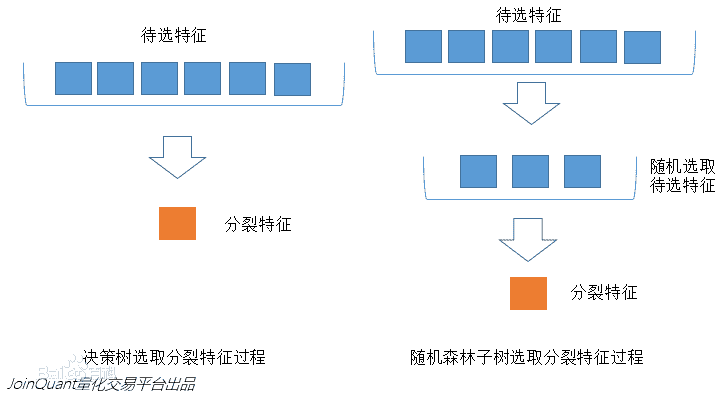

In [ ]:
import numpy as np
from random import randrange

In [ ]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []

    with open(fileName) as f:
        for line in f:
            lineArr = line.strip().split(',')
            dataLine = [float(x) for x in lineArr[:-1]]
            dataMat.append(dataLine)
            labelMat.append(lineArr[-1])

    return np.array(dataMat), np.array(labelMat)

# 生成一个 n 折的数据集划分
def crossValidationSplit(dataSet, n_folds):
    dataSetSplit = []
    dataSetCopy = list(dataSet)
    foldSize = len(dataSet) // n_folds

    for _ in range(n_folds):
        fold = []
        while len(fold) < foldSize:
            index = randrange(len(dataSetCopy))
            fold.append(dataSetCopy.pop(index))
        dataSetSplit.append(fold)
    
    return dataSetSplit

# 根据特征索引和特征值划分数据集
def testSplit(index, value, dataSet):
    left, right = [], []
    for row in dataSet:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# 计算Gini指数
def giniIndex(groups, classValues):
    """计算Gini指数，用于衡量数据集的纯度。

    Args:
        groups (list): 包含左、右两部分数据的列表。
        class_values (list): 数据集的所有分类标签。

    Returns:
        float: Gini指数。
    """
    gini = 0.0
    totalSize = sum(len(group for group in groups))

    for group in groups:
        size = len(group)
        if size == 0:
            continue

        score = 0.0
        for classVal in classValues:
            p = [row[-1] for row in group].count(classVal) / size
            score += p** 2
        
        gini += (1 - score) * (size / totalSize)
    
    return gini

# 选择最优的特征和特征值
def getSplit(dataSet, nFeatures):
    """寻找分割数据集的最佳特征和特征值。

    Args:
        dataset (list): 数据集。
        n_features (int): 特征数量的子集，用于随机森林中的特征选择。

    Returns:
        dict: 包含最佳特征索引、特征值及分割后的数据集。
    """

    classValues = list(set(row[-1] for row in dataSet))
    bestIndex, bestValue, bestScore, bestGroups = None, None, float('inf'), None
    features = []

    # 随机选择特征
    while len(features) < nFeatures:
        index = randrange(len(dataSet[0]) - 1)
        if index not in features:
            features.append(index)

    # 寻找最优分割点
    for index in features:
        for row in dataSet:
            groups = testSplit(index, row[index], dataSet)
            gini = giniIndex(groups, classValues)
            if gini < bestScore:
                bestIndex, bestValue, bestScore, bestGroups = index, row[index], gini, groups

    return {'index': bestIndex, 'value': bestValue, 'groups': bestGroups}



# 终止节点生成
def toTerminal(group):
    """
    创建一个终止节点，即叶节点。

    Args:
        group (list): 分割后的一组数据。

    Returns:
        分类标签: 该组数据中出现次数最多的标签。
    """
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# 递归分割节点
def split(node, maxDepth, minSize, nFeatures, depth):
    """
    递归分割节点，构建决策树。

    Args:
        node (dict): 当前节点信息。
        max_depth (int): 树的最大深度。
        min_size (int): 叶节点的最小数据量。
        n_features (int): 选取的特征数量。
        depth (int): 当前节点深度。
    """
    left, right = node['groups']
    # 删除已经分割的数据, 以免重复分割
    del(node['groups'])

    if not left or not right:
        node['left'] = node['right'] = toTerminal(left + right)
        return
    
    if depth >= maxDepth:
        node['left'], node['right'] = toTerminal(left), toTerminal(right)
        return
    
    if len(left) <= minSize:
        node['left'] = toTerminal(left)
    else:
        node['left'] = getSplit(left, nFeatures)
        split(node['left'], maxDepth, minSize, nFeatures, depth + 1)
    
    if len(right) <= minSize:
        node['right'] = toTerminal(right)
    else:
        node['right'] = getSplit(right, nFeatures)
        split(node['right'], maxDepth, minSize, nFeatures, depth + 1)

# 构建决策树
def buildTree(train, maxDepth, minSize, nFeatures):
    """
    构建决策树。

    Args:
        train (list): 训练数据。
        max_depth (int): 树的最大深度。
        min_size (int): 叶节点的最小数据量。
        n_features (int): 选取的特征数量。

    Returns:
        dict: 决策树。
    """
    root = getSplit(train, nFeatures)
    split(root, maxDepth, minSize, nFeatures, 1)
    return root

# 预测
def predict(node, row):
    """
    对输入数据进行预测。

    Args:
        node (dict): 决策树节点。
        row (list): 输入数据行。

    Returns:
        预测分类: 树预测的分类结果。
    """
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
# 随机森林，bagging预测
def baggingPredict(trees, row):
    """
    对输入数据进行bagging预测。

    Args:
        trees (list): 决策树集合。
        row (list): 输入数据行。

    Returns:
        预测分类: 多数决策树的预测结果。
    """

    results = [predict(tree, row) for tree in trees]
    return max(set(results), key=results.count)

# 随机抽取创建子样本
def subsample(dataSet, ratio):
    """
    从数据集中随机抽样创建子样本。

    Args:
        dataset (list): 数据集。
        ratio (float): 抽样比例。

    Returns:
        list: 子样本数据集。
    """

    sample = []
    nSample = round(len(dataSet) * ratio)
    
    while len(sample) < nSample:
        index = randrange(len(dataSet))
        sample.append(dataSet[index])
    return sample

# 随机森林算法
def randomForest(train, test, maxDepth, minSize, sampleRatio, nTrees, nFeatures):
    """
    构建随机森林模型并进行预测。

    Args:
        train (list): 训练数据。
        test (list): 测试数据。
        max_depth (int): 树的最大深度。
        min_size (int): 叶节点的最小数据量。
        sample_ratio (float): 子样本比例。
        n_trees (int): 决策树的数量。
        n_features (int): 随机选取的特征数量。

    Returns:
        list: 测试数据的预测结果。
    """

    trees = []
    for _ in range(nTrees):
        sample = subsample(train, sampleRatio)
        tree = buildTree(sample, maxDepth, minSize, nFeatures)
        trees.append(tree)
    
    predictions = [baggingPredict(trees, row) for row in test]
    return predictions

# 计算分类准确率
def accuracyMetric(actual, predicted):
    """计算预测的准确率。

    Args:
        actual (list): 实际标签。
        predicted (list): 预测标签。

    Returns:
        float
    """

    correct = sum(1 for i in range(len(actual)) if actual[i] == predicted[i])
    return correct / len(actual) * 100.0

# 交叉验证
def evaluate(dataSet, algorithm, nFolds, *args):
    """使用交叉验证评估算法性能。

    Args:
        dataset (list): 数据集。
        algorithm (function): 使用的算法函数。
        n_folds (int): 交叉验证折数。
        *args: 算法需要的其他参数。

    Returns:
        list: 每一折的准确率。
    """

    folds = crossValidationSplit(dataSet, nFolds)
    scores = []

    for fold in folds:
        train = sum([f for i, f in enumerate(folds) if i != fold], [])
        test = fold
        for row in test:
            row[-1] = None
        predicted = algorithm(train, test, *args)
        actual = [row[-1] for row in test]
        accuracy = accuracyMetric(actual, predicted)
        scores.append(accuracy)
    
    return scores